In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "C:/Users/jdzed/Downloads/dog_v1"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1030


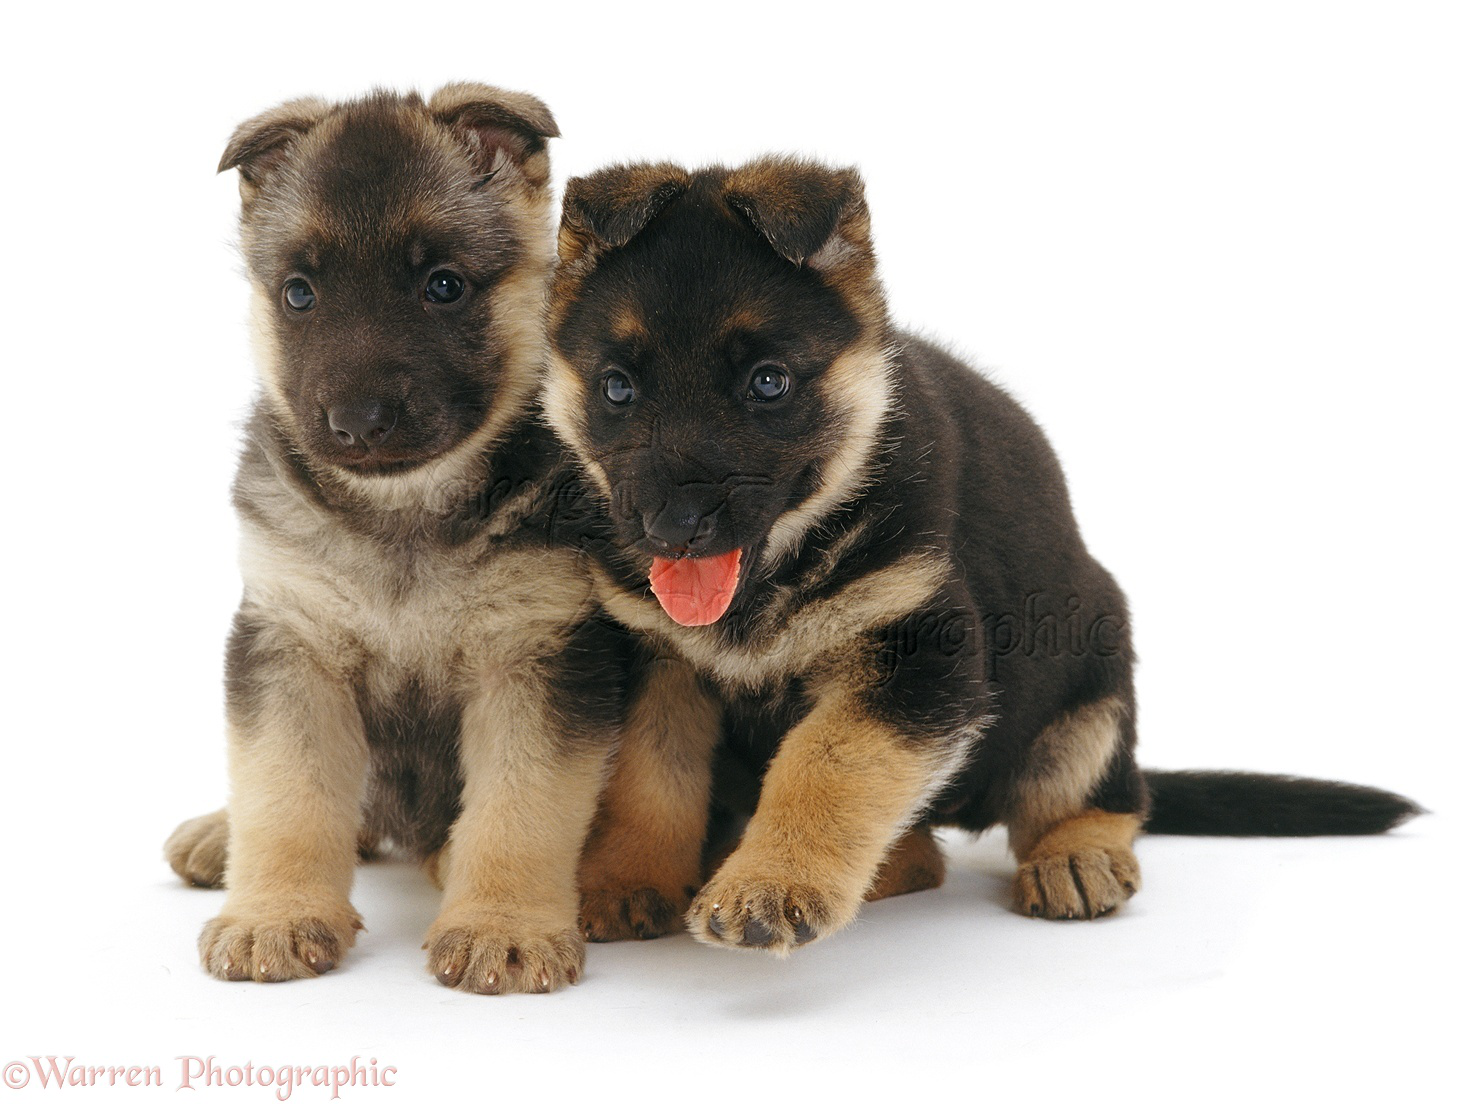

In [3]:
gs = list(data_dir.glob('german_shepherd/*'))
PIL.Image.open(str(gs[0]))

In [4]:
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1030 files belonging to 5 classes.
Using 824 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1030 files belonging to 5 classes.
Using 206 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['french_bulldog', 'german_shepherd', 'golden_retriever', 'poodle', 'yorkshire_terrier']


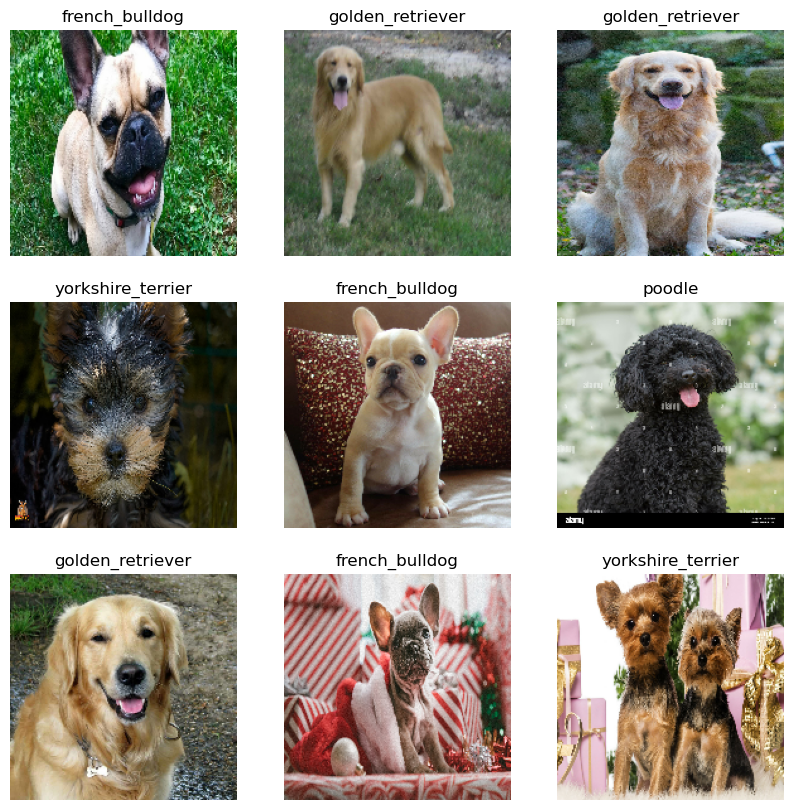

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.98643637


In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        5

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


26/26 [==============================] - 14s 463ms/step - loss: 2.0030 - accuracy: 0.2027 - val_loss: 1.6127 - val_accuracy: 0.1553
Epoch 2/10
26/26 [==============================] - 9s 336ms/step - loss: 1.6081 - accuracy: 0.2318 - val_loss: 1.5923 - val_accuracy: 0.2573
Epoch 3/10
26/26 [==============================] - 8s 294ms/step - loss: 1.6012 - accuracy: 0.2367 - val_loss: 1.5860 - val_accuracy: 0.2573
Epoch 4/10
26/26 [==============================] - 8s 300ms/step - loss: 1.5998 - accuracy: 0.2391 - val_loss: 1.5878 - val_accuracy: 0.2864
Epoch 5/10
26/26 [==============================] - 8s 297ms/step - loss: 1.5945 - accuracy: 0.2379 - val_loss: 1.5687 - val_accuracy: 0.2524
Epoch 6/10
26/26 [==============================] - 9s 337ms/step - loss: 1.5309 - accuracy: 0.3289 - val_loss: 1.4596 - val_accuracy: 0.3738
Epoch 7/10
26/26 [==============================] - 8s 323ms/step - loss: 1.3645 - accuracy: 0.4272 - val_loss: 1.4527 - val_accuracy: 0.3350
Epo

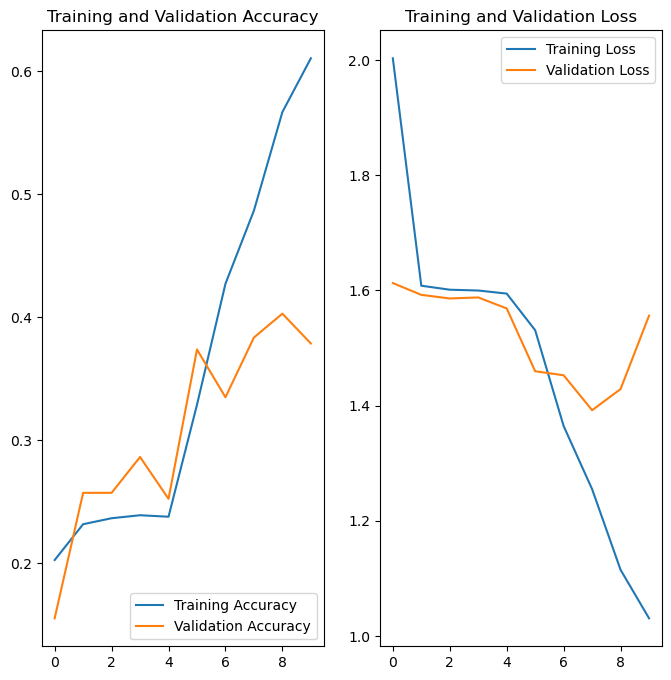

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()